# Data Cleaning
This notebook aims to clean the raw data and outputs it so it as a `.pkl` file in order to be used used for future feature selection and engineering steps. There are some caveats when it comes to outliers, especially for the `item_price`. Since we need this variable to calculate the cost later on, we can not simply cap `item_price` outliers or transform them.


## Table of Contents
* [1.Import Data](#import_data)
    * [1.1 Change Data Types](#change_dtypes)
* [2.Find and Impute Vales](#find_impute_values)
    * [2.1  Imputing and Cleaning of `delivery_date`](#impute_delivery)
    * [ 2.2 Imputing and cleaning of  `user_dob`](#impute_user_dob)
* [3.Outliers and Invalid values](#outliers_invalid)
    * [ 3.1 `item_price`](#item_price)
    * [ 3.2 Categorical Data](#categorical)
        * [ 3.2.1 `item_color`](#item_color)
        * [ 3.2.2 `item_size`](#item_size)
    * [ 3.3 Datetime Values](#datetime)
* [4.Export Cleaned Data](#export)
        


In [91]:
# Required Packages

#DS Packages
import pandas as pd
import numpy as np

#Utils
from dateutil.relativedelta import relativedelta
from datetime import datetime
from datetime import timedelta

#Data Viualization
import seaborn as sns
import matplotlib.pyplot as plt

# always display plots inline 
%matplotlib inline 
sns.set(style='darkgrid')

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Random Seed Constant
random_seed = 420

#set numpy random seed 
np.random.seed(random_seed)

#Custom Util funcs
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#import custom utility functions     
from src.d00_utils.utility import print_full, make_lowercase, fix_spelling_mistakes



#### Data Cleaning Functions

In [92]:
def cap_outliers(col, iqr_threshold=1.5, verbose=False, no_negative = False, manual_bounds = False, cap_only_lower=False):
    '''Caps outliers to closest existing value within threshold (IQR).'''
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    lbound = Q1 - iqr_threshold * IQR
    ubound = Q3 + iqr_threshold * IQR
    if no_negative:
        if lbound < 0:
            lbound = 0
        
    outliers = (col < lbound) | (col > ubound)
    if verbose:
        print(f'  Number of outliers:{len(outliers)}')
    
    col.loc[col < lbound] = col.loc[~outliers].min()
    if cap_only_lower:
        return col
    col.loc[col > ubound] = col.loc[~outliers].max()

    if verbose:
            print('\n'.join(
                ['Capping outliers by the IQR method:',
                 f'   IQR threshold: {iqr_threshold}',
                 f'   Lower bound: {lbound}',
                 f'   Upper bound: {ubound}\n']))

    return col

In [93]:
def get_category_level_diffs(series_arr):
    
    series_arr = make_lowercase(series_arr)
    
    series_1_cats =  series_arr[0].cat.categories
    series_2_cats =  series_arr[1].cat.categories 
    

    diffs = list(set(series_1_cats).symmetric_difference(set(series_2_cats)))
    print(f'Number of different Category Levels between datasets: {len(diffs)}')
    return diffs

In [94]:
def unify_cat_levels(series_arr):
    
    series_arr = make_lowercase(series_arr)
    diffs = get_category_level_diffs(series_arr)
    
    
    for i in range(len(series_arr)):
        series_arr[i] = ['diff' if x in diffs else x for x in series_arr[i]]
        print(f'Series {i+1}: values unified')
        print(f'Number of rows with diff category level: {series_arr[i].count("diff")}')
    
    return series_arr[0], series_arr[1] 

## 1. Import Data
<a id="import_data"></a>

In [95]:
#Known Data Set
df = pd.read_csv('../data/01_raw/BADS_WS2021_known.csv')
df.name = 'Known Data'

#Unknown Data Set
df_unknown = pd.read_csv('../data/01_raw/BADS_WS2021_unknown.csv')
df_unknown.name = 'Unknown Data'

In [96]:
# check if data was correctly loaded
df.head(2)

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
1,2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0


In [97]:
df_unknown.head(2)

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date
0,100001,2016-10-15,2017-01-10,1591,40,anthracite,9,69.9,56943,Mrs,1967-09-18,Baden-Wuerttemberg,2016-10-16
1,100002,2016-10-15,2017-01-10,1589,m,red,11,69.9,56943,Mrs,1967-09-18,Baden-Wuerttemberg,2016-10-16


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_item_id  100000 non-null  int64  
 1   order_date     100000 non-null  object 
 2   delivery_date  90682 non-null   object 
 3   item_id        100000 non-null  int64  
 4   item_size      100000 non-null  object 
 5   item_color     100000 non-null  object 
 6   brand_id       100000 non-null  int64  
 7   item_price     100000 non-null  float64
 8   user_id        100000 non-null  int64  
 9   user_title     100000 non-null  object 
 10  user_dob       91275 non-null   object 
 11  user_state     100000 non-null  object 
 12  user_reg_date  100000 non-null  object 
 13  return         100000 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 10.7+ MB


Here we can see that the `order_item_id` apperantly follows a different format, hence we should change the `order_item_id` of our *known df*, since our final predictions will be made on the *unknown df* index format.

In [99]:
#add 100000 to each order_item_id 
df['order_item_id'] = df['order_item_id']
df['order_item_id'] = df['order_item_id']+ 100000
#set order_item_id as index
df.set_index('order_item_id', inplace = True)
df_unknown.set_index('order_item_id',inplace = True)

## 1.2 Change Data Types of variables
<a id="change_dtypes"></a>
This dataset contains mostly categorical variables, four date_time variables (no time) and one numeric variable.

In [100]:
def changeDtypes(_df):
    # date_time variables
    date_vars = ['order_date',
                 'delivery_date',
                 'user_dob',
                 'user_reg_date']
    #category variables
    category_vars = ['item_size',
                     'item_color',
                     'user_title',
                     'user_state',
                     'brand_id',
                     'item_id',
                     'user_id']
    # numeric variables
    numeric_vars = 'item_price'
    
    # Convert to appropriate variable dtype
    _df[date_vars] = _df[date_vars].astype('datetime64[ns]')
    _df[category_vars] = _df[category_vars].astype('category')
    _df[numeric_vars] = _df[numeric_vars].astype(np.float32)
    return _df

In [101]:
# change dtypes for both df's
df = changeDtypes(df)
df_unknown = changeDtypes(df_unknown)

In [102]:
#check if all categories have been assigned correctly
print('\n================================> KOWN DF <=====================================')
df.info()
print('\n================================> UNKOWN DF <=====================================')
df_unknown.info()


================================> KOWN DF <=====================================
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100001 to 200000
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_date     100000 non-null  datetime64[ns]
 1   delivery_date  90682 non-null   datetime64[ns]
 2   item_id        100000 non-null  category      
 3   item_size      100000 non-null  category      
 4   item_color     100000 non-null  category      
 5   brand_id       100000 non-null  category      
 6   item_price     100000 non-null  float32       
 7   user_id        100000 non-null  category      
 8   user_title     100000 non-null  category      
 9   user_dob       91275 non-null   datetime64[ns]
 10  user_state     100000 non-null  category      
 11  user_reg_date  100000 non-null  datetime64[ns]
 12  return         100000 non-null  int64         
dtypes: category(7), d

## 2 Find and impute missing data
<a id="find_impute_values"></a>
Next we will check if there are any missing values in our dataset and impute the missing values. Since our final prediction has to be made for all 50.000 entries, we do not have the option to drop any missing values, because we need to perform the same mutations on both datasets.

In [103]:
# Generate a list of missing values
df.isnull().sum()

order_date          0
delivery_date    9318
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_dob         8725
user_state          0
user_reg_date       0
return              0
dtype: int64

As we can see, we have some missing values for both `delivery_date` and `user_dob`. For the `user_dob` we will impute the missing values using random values from the distribution, for the `delivery_date` we will rather add the median `delivery_time` of the non-null values to the `order_date` to impute the `delivery_date`.

### 2.1 Imputing and Cleaning of `delivery_date`
<a id="impute_delivery"> </a>

In [104]:
df['delivery_date'].describe(datetime_is_numeric=True)

count                            90682
mean     2016-05-06 01:34:39.522085376
min                1994-12-31 00:00:00
25%                2016-07-16 00:00:00
50%                2016-08-08 00:00:00
75%                2016-08-28 00:00:00
max                2017-01-24 00:00:00
Name: delivery_date, dtype: object

In [105]:
print('Known Data:\n',df['delivery_date'].apply(lambda x: x.year).value_counts(), '\n')
print('Unknown Data:\n',df_unknown['delivery_date'].apply(lambda x: x.year).value_counts())

Known Data:
 2016.0    89607
1994.0     1072
2017.0        3
Name: delivery_date, dtype: int64 

Unknown Data:
 2016.0    42244
2017.0     1402
1994.0      509
Name: delivery_date, dtype: int64


Above we see that most values are either from the end of 2016 or the beginning of 2017. Some values however seem to be 22 years before 2016. Therefore one could arguebly conclude that these entries were wrongly entered or somehow corrupted by the system. Thus, we will add 22 years to all of these values.

In [106]:
#iterate through all entries and add 22 years to all entries that are lower than 2016
df['delivery_date'] = df['delivery_date'].apply(
    lambda x: x + relativedelta(years=22) 
    if x.year < 2016 \
    else x)
df_unknown['delivery_date'] = df_unknown['delivery_date'].apply(
    lambda x: x + relativedelta(years=22)  
    if x.year < 2016 \
    else x )

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100001 to 200000
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_date     100000 non-null  datetime64[ns]
 1   delivery_date  90682 non-null   datetime64[ns]
 2   item_id        100000 non-null  category      
 3   item_size      100000 non-null  category      
 4   item_color     100000 non-null  category      
 5   brand_id       100000 non-null  category      
 6   item_price     100000 non-null  float32       
 7   user_id        100000 non-null  category      
 8   user_title     100000 non-null  category      
 9   user_dob       91275 non-null   datetime64[ns]
 10  user_state     100000 non-null  category      
 11  user_reg_date  100000 non-null  datetime64[ns]
 12  return         100000 non-null  int64         
dtypes: category(7), datetime64[ns](4), float32(1), int64(1)
memory usage: 6.8 MB


Now we can find the **median** `delivery_time` and add this to the `order_date` of the missing entries in order to impute the missing `delivery_date`. We use the median since it should be more robust than the *mean*.

In [108]:
def impute_delivery_time(_df, verbose = False):
    print(f'Imputing Delivery times for: {_df.name}')
    # create df with only nonNA values of order date and delivery date
    df_order_delivery = _df[['order_date', 'delivery_date']].dropna()
    
    #use timedelta to calculate difference between order and delivery date
    df_delivery_time = df_order_delivery.apply(
        lambda x: (x['delivery_date'] - x['order_date']).days,
        axis = 1,
        result_type='expand')
    
    # compoute mean_deliver_time
    mean_deliver_time = df_delivery_time.median()
    
    if verbose:
        print('Mean Delivery Time is: ',mean_deliver_time)
        
    #add median delivery_time to order date of missing values
    _df['delivery_date'] =_df.apply(
        lambda x: x['order_date'] + timedelta(days=mean_deliver_time) \
        if pd.isnull(x['delivery_date']) \
        else x['delivery_date'], axis=1, result_type='expand')
    if verbose:
        print('No. of Missing Values after imputation:',_df['delivery_date'].isnull().sum())
    return _df

In [109]:
df = impute_delivery_time(df, verbose = True)
df_unknown = impute_delivery_time(df_unknown, verbose = True)

Imputing Delivery times for: Known Data
Mean Delivery Time is:  3.0
No. of Missing Values after imputation: 0
Imputing Delivery times for: Unknown Data
Mean Delivery Time is:  3.0
No. of Missing Values after imputation: 0


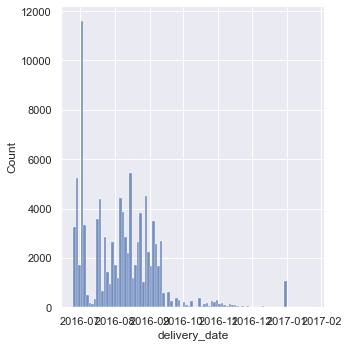

In [110]:
sns.displot(df['delivery_date'])

### 2.2 Imputing and cleaning of  `user_dob`
<a id = "impute_user_dob"></a>

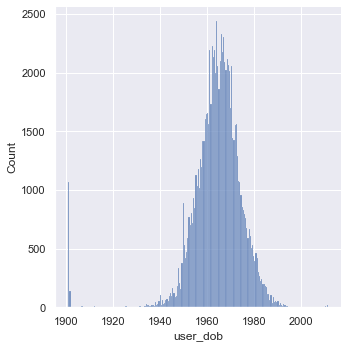

In [111]:
sns.displot(df['user_dob'])

Again, before imputing any values we should clean the data. Considering that people from the early 1900s are most likely not alive anymore and were most likely entered in an attempt of not entering their actual date of birth or due to a systematic error within the database system. Therefore, we will first impute all user birth dates which are lower than 1920 (meanning roughly all users that are older than 100 years) by using a random date following the distribution.

In [112]:
# get normalized distribution of all user_dob that are higher than 1920
vc = df['user_dob'][df['user_dob'].dt.year > 1920].value_counts(normalize=True)
# insert random value following the distribution
df['user_dob'] = df['user_dob'].apply(lambda x: np.random.choice(vc.index, p=vc.values) if x.year < 1920 else x)

We can now impute the missing values using random values following the distribution.

In [113]:
def impute_na_user_dob(col):
    # get normalized distribution 
    vc = col.value_counts(normalize=True)
    # fill na values wih randomized values following the distribution
    return np.random.choice(vc.index, p=vc.values, size=col.isna().sum()) 

In [114]:
df.loc[df['user_dob'].isna(), 'user_dob'] = impute_na_user_dob(df['user_dob'])

In [115]:
df_unknown.loc[df_unknown['user_dob'].isna(), 'user_dob'] = impute_na_user_dob(df_unknown['user_dob'])

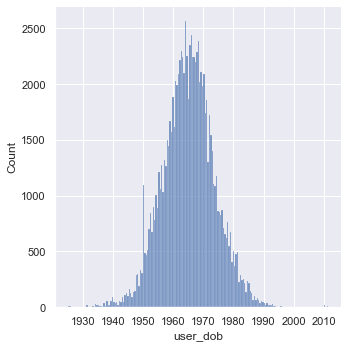

In [116]:
sns.displot(df['user_dob'])

There are still some outliers in the distribution, however we decided to keep them in, since a lot of information on the younger birth dates would be lost, only keeping information on users which are roughly 30 years old. 

In [117]:
# check if there are no missing values
print (df.isnull().sum().sum())
print( df_unknown.isnull().sum().sum())

0
0


## 3. Outliers and Invalid Values
<a id='outliers_invalid'></a>
In this chapter we will go through all features and correct potential outliers and invalid values.

### 3.1 `Item_price`
<a id ='item_price'></a>

In [118]:
df['item_price'].describe()

count    100000.000000
mean         65.111557
std          47.989960
min           0.000000
25%          29.900000
50%          49.900002
75%          79.900002
max         999.000000
Name: item_price, dtype: float64

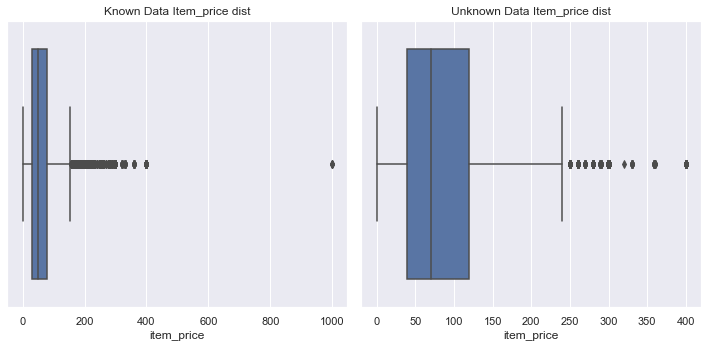

In [119]:
fig,axes = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(df['item_price'],ax=axes[0])
axes[0].set_title('Known Data Item_price dist')
sns.boxplot(df_unknown['item_price'],ax = axes[1])
axes[1].set_title('Unknown Data Item_price dist')
plt.tight_layout()

Above one can see that there are some outliers on the upper end of the spectrum, even ranging up to 999€. Since our model evalation depends on the `item_price` to calculate the cost associated with wrongly classifiying an order, we will not cap any outliers since this would distort the data too much.

### 3.2 Categorical Data
<a id="categorical"></a>

#### 3.2.1 `item_color`
<a id="item_color"></a>

In [120]:
print_full(df_unknown['item_color'].value_counts().index)

CategoricalIndex(['black', 'brown', 'red', 'grey', 'blue', 'green', 'petrol', 'anthracite', 'purple', 'mocca', 'berry', 'aubergine', 'white', 'olive', 'dark denim', 'stained', 'ocher', 'turquoise', 'pink', 'ash', 'beige', 'nature', 'pallid', 'bordeaux', 'aquamarine', 'denim', 'coral', 'basalt', 'navy', 'orange', 'yellow', 'mahagoni', 'blau', 'magenta', 'ancient', 'khaki', 'cognac', 'striped', 'dark navy', 'azure', 'curry', 'floral', '?', 'dark oliv', 'ivory', 'silver', 'ecru', 'habana', 'dark garnet', 'darkblue', 'fuchsia', 'terracotta', 'hibiscus', 'jade', 'mango', 'brwon', 'antique pink', 'champagner', 'cobalt blue', 'creme', 'kanel', 'almond', 'copper coin', 'aqua', 'aviator', 'gold', 'ebony'], categories=['?', 'almond', 'ancient', 'anthracite', 'antique pink', 'aqua', 'aquamarine', 'ash', ...], ordered=False, dtype='category')


In [121]:
print_full(df_unknown['item_color'].value_counts().index)

CategoricalIndex(['black', 'brown', 'red', 'grey', 'blue', 'green', 'petrol', 'anthracite', 'purple', 'mocca', 'berry', 'aubergine', 'white', 'olive', 'dark denim', 'stained', 'ocher', 'turquoise', 'pink', 'ash', 'beige', 'nature', 'pallid', 'bordeaux', 'aquamarine', 'denim', 'coral', 'basalt', 'navy', 'orange', 'yellow', 'mahagoni', 'blau', 'magenta', 'ancient', 'khaki', 'cognac', 'striped', 'dark navy', 'azure', 'curry', 'floral', '?', 'dark oliv', 'ivory', 'silver', 'ecru', 'habana', 'dark garnet', 'darkblue', 'fuchsia', 'terracotta', 'hibiscus', 'jade', 'mango', 'brwon', 'antique pink', 'champagner', 'cobalt blue', 'creme', 'kanel', 'almond', 'copper coin', 'aqua', 'aviator', 'gold', 'ebony'], categories=['?', 'almond', 'ancient', 'anthracite', 'antique pink', 'aqua', 'aquamarine', 'ash', ...], ordered=False, dtype='category')


When looking at the category leveles we spot some spelling mistakes which we will correct below. Additionally we will change the value of '?' to 'undefined' to be more descriptive.

In [122]:
# dict of spelling mistakes to correct
colors_spelling_mistakes = {
  'brwn' : 'brown', 
  'blau' : 'blue',
  '?': 'undefined' 
}
#fix spelling mistakes for both datasets
df['item_color'] = fix_spelling_mistakes(df['item_color'], colors_spelling_mistakes)
df_unknown['item_color'] = fix_spelling_mistakes(df_unknown['item_color'],colors_spelling_mistakes)

Some algorithms cannot perform when the category levels between the known and the unknown data set are different. Therefore, we will unify the category levels.

In [123]:
get_category_level_diffs([df['item_color'], df_unknown['item_color']])

Number of different Category Levels between datasets: 10


['curled',
 'opal',
 'currant purple',
 'mint',
 'baltic blue',
 'dark grey',
 'caramel',
 'apricot',
 'avocado',
 'amethyst']

In [124]:
df['item_color'], df_unknown['item_color'] = unify_cat_levels([df['item_color'], df_unknown['item_color']])

Number of different Category Levels between datasets: 10
Series 1: values unified
Number of rows with diff category level: 247
Series 2: values unified
Number of rows with diff category level: 0


#### 3.2.2 `item_size`
<a id="item_size"></a>

In [125]:
df['item_size'].value_counts()

l       12347
xl      10979
m       10190
xxl      8966
40       7693
        ...  
84          1
105         1
3634        1
4034        1
49          1
Name: item_size, Length: 102, dtype: int64

In [126]:
df_unknown['item_size'].value_counts()

unsized    4049
40         3927
L          3391
l          2910
XL         2839
           ... 
100           2
12+           2
4232          1
110           1
95            1
Name: item_size, Length: 103, dtype: int64

As already discussed above in `item_color`, we will have to unify category levels. Also some category levels are uppercased/undercased in our two dataset. Luckily `unify_cat_levels()` also takes care of that by lowercasing all values.

In [127]:
df['item_size'], df_unknown['item_size'] = unify_cat_levels([df['item_size'], df_unknown['item_size']])

Number of different Category Levels between datasets: 14
Series 1: values unified
Number of rows with diff category level: 16
Series 2: values unified
Number of rows with diff category level: 6


#### 3.2.3 `user_title`
<a id="user_title"></a>
The category levels of `user_title` seem to be in sync.

In [128]:
df['user_title'].value_counts()

Mrs             95429
Mr               3915
Family            414
Company           128
not reported      114
Name: user_title, dtype: int64

In [129]:
df_unknown['user_title'].value_counts()

Mrs             47969
Mr               1819
Family            181
not reported       20
Company            11
Name: user_title, dtype: int64

#### 3.2.4 Other Categorical Features
- `user_state` --> No differences in category levels
- `item_id` --> Differences in category levels, but needed for future Feature Engineering steps
- `brand_id` --> Differences in category levels, but needed for future Feature Engineering steps

`user_id`'s are too different in both datasets to be considered a useful feature, see below:

In [130]:
user_ids_unified, user_ids_unknown_unified = unify_cat_levels([df['user_id'], df_unknown['user_id']])

Number of different Category Levels between datasets: 23559
Series 1: values unified
Number of rows with diff category level: 70575
Series 2: values unified
Number of rows with diff category level: 32245


### 3.3 Datetime values
<a id="datetime"></a>
First, we should check if there are any instances of a `delivery_date` occuring **before** the `order_date`.

In [131]:
for index, row in df[['order_date', 'delivery_date']].iterrows():
    if row['delivery_date'] < row ['order_date']:
        print('Found one at index', index)

In [132]:
for index, row in df_unknown[['order_date', 'delivery_date']].iterrows():
    if row['delivery_date'] < row ['order_date']:
        print('Found one at index', index)

This doesen't seem to be the case, tested with both datasets.
There are some entries which have the same `delivery_date` and `order_date`. However same-day-delivery is a possible explanation for this. Since we do not know more about the e-commerce shop, we will leave the values as they are.

Next, we do the same with `order_date` and `user_reg_date`.

In [133]:
number_of_users_ordered_before_registered = 0
for index, row in df[['user_reg_date', 'order_date']].iterrows():
    if row['user_reg_date'] > row ['order_date']:
        number_of_users_ordered_before_registered+=1
        
print(number_of_users_ordered_before_registered)

20255


Here we have over 20000 cases in which a user was registered after an order has been made. This is often the case if ecommerce shops allow for ordering without registering. We can use this information later on in the feature enigineering step.

## 4. Export Cleaned Data 
<a id="export"></a>
At the end of each notebook we will export the dataframes in a `.pkl` format. This format also saves all dtypes we assigned to each column, making it easier to load and work with in different notebooks.

In [134]:
# Somewhere Dtypes have been changed..
df = changeDtypes(df)
df_unknown = changeDtypes(df_unknown)

In [135]:
# Sanity check
print('\n================================> KOWN DF <=====================================')
df.info()
print('\n================================> UNKOWN DF <=====================================')
df_unknown.info()


================================> KOWN DF <=====================================
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100001 to 200000
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_date     100000 non-null  datetime64[ns]
 1   delivery_date  100000 non-null  datetime64[ns]
 2   item_id        100000 non-null  category      
 3   item_size      100000 non-null  category      
 4   item_color     100000 non-null  category      
 5   brand_id       100000 non-null  category      
 6   item_price     100000 non-null  float32       
 7   user_id        100000 non-null  category      
 8   user_title     100000 non-null  category      
 9   user_dob       100000 non-null  datetime64[ns]
 10  user_state     100000 non-null  category      
 11  user_reg_date  100000 non-null  datetime64[ns]
 12  return         100000 non-null  int64         
dtypes: category(7), d

In [136]:
df.to_pickle('../data/02_intermediate/BADS_WS2021_known_cleaned.pkl')
df_unknown.to_pickle('../data/02_intermediate/BADS_WS2021_unknown_cleaned.pkl')